In [1]:
import sys
import os
import gc
import copy
import yaml
import random
import shutil
from time import time
import typing as tp
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedGroupKFold

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.cuda import amp

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

ROOT = Path.cwd().parent
INPUT = ROOT / "input"
OUTPUT = ROOT / "output"
SRC = ROOT / "src"

DATA = INPUT / "train-updated-missingvalue"
TRAIN_SPEC = DATA / "train_spectrograms"
TEST_SPEC = DATA / "test_spectrograms"

TMP = ROOT / "tmp"
TRAIN_SPEC_SPLIT = TMP / "train_spectrograms_split"
TEST_SPEC_SPLIT = TMP / "test_spectrograms_split"
TMP.mkdir(exist_ok=True)
TRAIN_SPEC_SPLIT.mkdir(exist_ok=True)
TEST_SPEC_SPLIT.mkdir(exist_ok=True)


RANDAM_SEED = 1086
CLASSES = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
N_CLASSES = len(CLASSES)
# FOLDS = [0, 1, 2, 3, 4]
FOLDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
N_FOLDS = len(FOLDS)

train = pd.read_csv(DATA / "train_updated.csv")

# convert vote to probability
# train[CLASSES] /= train[CLASSES].sum(axis=1).values[:, None]

print(train.shape)


train_df1 = train[(train['eeg_NaN_num'] <= 0) & (train['spec_NaN_num'] <= 0)]
len(train_df1)

train = train_df1


# import pandas as pd

# 假设df是你的DataFrame，columns是你提到的列
columns = ['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

# 选择唯一行
unique_rows = train.drop_duplicates(subset=columns, keep='first').reset_index(drop=True)
train = unique_rows


train['total_votes'] = train[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)
train['target'] = train['expert_consensus']
# convert vote to probability
train[CLASSES] /= train[CLASSES].sum(axis=1).values[:, None]

print(train.shape)


pop_1_idx = train['total_votes'] < 10
train_pop_1 = train[pop_1_idx].copy().reset_index(drop=True)
train_pop_2 = train[~pop_1_idx].copy().reset_index(drop=True)

# train = train_pop_1

train["fold"] = -1

sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDAM_SEED)
for fold_id, (_, val_idx) in enumerate(
    sgkf.split(train, y=train["expert_consensus"], groups=train["patient_id"])
):
    train.loc[val_idx, "fold"] = fold_id
    


(106800, 17)
(18480, 19)


In [3]:
import matplotlib.pyplot as plt

In [4]:
train.head(1)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_NaN_num,spec_NaN_num,total_votes,target,fold
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,0,0,3,Seizure,3


In [2]:
combine_data = np.load('/kaggle/input/missingvalue/combine_missingValue.npy',allow_pickle=True).item()

In [5]:
img = combine_data[127492639]

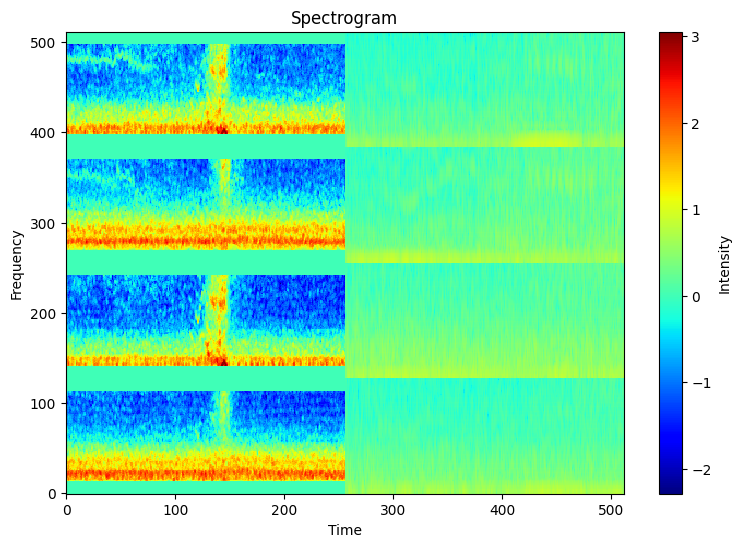

In [7]:
plt.figure(figsize=(9, 6))
plt.imshow(img, aspect='auto', origin='lower', cmap='jet', interpolation='nearest',
           )
plt.colorbar(label='Intensity')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.show()

In [ ]:


class HMSHBACSpecModel(nn.Module):

    def __init__(
            self,
            model_name: str,
            pretrained: bool,
            in_channels: int,
            num_classes: int,
        ):
        super().__init__()
        self.model = timm.create_model(
            model_name=model_name, pretrained=pretrained,
            num_classes=num_classes, in_chans=in_channels)

    def forward(self, x):
        h = self.model(x)      

        return h
    
    
FilePath = tp.Union[str, Path]
EegIds = tp.Union[str, Path]
Label = tp.Union[int, float, np.ndarray]

class HMSHBACSpecDataset(torch.utils.data.Dataset):

    def __init__(
        self,
        eeg_ids: tp.Sequence[EegIds],
        image_paths: tp.Sequence[FilePath],
        labels: tp.Sequence[Label],
        transform: A.Compose,
    ):
        self.eeg_ids = eeg_ids
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index: int):
        img_path = self.image_paths[index]
        eeg_id = self.eeg_ids[index]
                
        label = self.labels[index]
        img = combine_data[img_path]
        img = self._apply_transform(img)

        return {"data": img, "target": label}

    def _apply_transform(self, img: np.ndarray):
        """apply transform to image and mask"""
        transformed = self.transform(image=img)
        img = transformed["image"]
        return img
    
    
class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss


class KLDivLossWithLogitsForVal(nn.KLDivLoss):
    
    def __init__(self):
        """"""
        super().__init__(reduction="batchmean")
        self.log_prob_list  = []
        self.label_list = []

    def forward(self, y, t):
        y = nn.functional.log_softmax(y, dim=1)
        self.log_prob_list.append(y.numpy())
        self.label_list.append(t.numpy())
        
    def compute(self):
        log_prob = np.concatenate(self.log_prob_list, axis=0)
        label = np.concatenate(self.label_list, axis=0)
        final_metric = super().forward(
            torch.from_numpy(log_prob),
            torch.from_numpy(label)
        ).item()
        self.log_prob_list = []
        self.label_list = []
        
        return final_metric
    
    
# 
class CFG:
    model_name = "tf_efficientnetv2_s.in21k_ft_in1k"
    img_size = 512
    max_epoch = 10
    batch_size = 32
    lr = 1.0e-03
    weight_decay = 1.0e-02
    es_patience =  5
    seed = 1086
    deterministic = True
    enable_amp = True
    device = "cuda"
    
def set_random_seed(seed: int = 42, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = deterministic  # type: ignore
    
def to_device(
    tensors: tp.Union[tp.Tuple[torch.Tensor], tp.Dict[str, torch.Tensor]],
    device: torch.device, *args, **kwargs
):
    if isinstance(tensors, tuple):
        return (t.to(device, *args, **kwargs) for t in tensors)
    elif isinstance(tensors, dict):
        return {
            k: t.to(device, *args, **kwargs) for k, t in tensors.items()}
    else:
        return tensors.to(device, *args, **kwargs)
    
    
def time_masking(spec, max_mask=0.2):
    """
    对频谱图应用时间遮蔽。
    
    参数：
    - spec: 输入的频谱图，形状为 [time_steps, freq_bins, channels]
    - max_time_mask: 最大的时间遮蔽长度
    
    返回值：
    - masked_spec: 应用时间遮蔽后的频谱图
    """
    freq_bins,time_steps,channels = spec.shape
    masked_spec = spec.copy()
    max_mask_start = time_steps - int(max_mask*time_steps)
    mask_start = np.random.randint(0, max_mask_start)
    mask_end = mask_start + np.random.randint(0, int(max_mask*time_steps))
    masked_spec[:, mask_start:mask_end, :] = 0
    return masked_spec


def freq_masking(spec, max_mask=0.2):
    """
    对频谱图应用频率遮蔽。
    
    参数：
    - spec: 输入的频谱图，形状为 [time_steps, freq_bins, channels]
    - max_freq_mask: 最大的频率遮蔽长度
    
    返回值：
    - masked_spec: 应用频率遮蔽后的频谱图
    """
    freq_bins,time_steps,channels = spec.shape
#     print("freq_bins:",freq_bins)
    masked_spec = spec.copy()
    max_mask_start = freq_bins - int(max_mask*freq_bins)
    mask_start = np.random.randint(0, max_mask_start)
    mask_end = mask_start + np.random.randint(0, int(max_mask*freq_bins))
#     print(f"mask_start:{mask_start},end:{mask_end}")
    masked_spec[mask_start:mask_end, :, :] = 0
    return masked_spec


class TimeMasking(A.DualTransform):
    def __init__(self, max_mask=0.2, always_apply=False, p=0.5):
        super(TimeMasking, self).__init__(always_apply, p)
        self.max_mask = max_mask

    def apply(self, image, **params):
        return time_masking(image, self.max_mask)

class FreqMasking(A.DualTransform):
    def __init__(self, max_mask=0.2, always_apply=False, p=0.5):
        super(FreqMasking, self).__init__(always_apply, p)
        self.max_mask = max_mask

    def apply(self, spec, **params):
        return freq_masking(spec, self.max_mask)
    
    
def get_path_label(val_fold, train_all: pd.DataFrame):
    """Get file path and target info."""
    
    train_idx = train_all[train_all["fold"] != val_fold].index.values
    val_idx   = train_all[train_all["fold"] == val_fold].index.values
    img_paths = []
    eeg_ids = []
    labels = train_all[CLASSES].values
    for label_id in train_all["label_id"].values:
#         img_path = TRAIN_SPEC_SPLIT / f"{label_id}.npy"
        train1 = train[train['label_id']==label_id]
        eeg_id = train1['eeg_id'].values[0]
        
        img_path = label_id
        eeg_ids.append(eeg_id)
        img_paths.append(img_path)

    train_data = {
        "eeg_ids": [eeg_ids[idx] for idx in train_idx],
        "image_paths": [img_paths[idx] for idx in train_idx],
        "labels": [labels[idx].astype("float32") for idx in train_idx]}

    val_data = {
        "eeg_ids": [eeg_ids[idx] for idx in val_idx],
        "image_paths": [img_paths[idx] for idx in val_idx],
        "labels": [labels[idx].astype("float32") for idx in val_idx]}
    
    return train_data, val_data, train_idx, val_idx


def get_transforms(CFG):
    train_transform = A.Compose([
        A.Resize(p=1.0, height=CFG.img_size, width=CFG.img_size),
        TimeMasking(max_mask=0.2, p=0.5),
        FreqMasking(max_mask=0.2, p=0.5),
        ToTensorV2(p=1.0)
    ])
    val_transform = A.Compose([
        A.Resize(p=1.0, height=CFG.img_size, width=CFG.img_size),
        ToTensorV2(p=1.0)
    ])
    return train_transform, val_transform

def train_one_fold(CFG, val_fold, train_all, output_path,fold_id,stage_id):
    """Main"""
    torch.backends.cudnn.benchmark = True
    set_random_seed(CFG.seed, deterministic=CFG.deterministic)
    device = torch.device(CFG.device)
    
    train_path_label, val_path_label, _, _ = get_path_label(val_fold, train_all)
    train_transform, val_transform = get_transforms(CFG)
    
    train_dataset = HMSHBACSpecDataset(**train_path_label, transform=train_transform)
    val_dataset = HMSHBACSpecDataset(**val_path_label, transform=val_transform)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
    
    model = HMSHBACSpecModel(
        model_name=CFG.model_name, pretrained=True, num_classes=6, in_channels=1)
    model.to(device)
    if stage_id == 2:
        model.load_state_dict(torch.load(f'./stage1/best_model_fold{val_fold}.pth', map_location=device))
    optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = lr_scheduler.OneCycleLR(
        optimizer=optimizer, epochs=CFG.max_epoch,
        pct_start=0.0, steps_per_epoch=len(train_loader),
        max_lr=CFG.lr, div_factor=25, final_div_factor=4.0e-01
    )
    
    loss_func = KLDivLossWithLogits()
    loss_func.to(device)
    loss_func_val = KLDivLossWithLogitsForVal()
    
    use_amp = CFG.enable_amp
    scaler = amp.GradScaler(enabled=use_amp)
    
    best_val_loss = 1.0e+09
    best_epoch = 0
    train_loss = 0
    
    for epoch in range(1, CFG.max_epoch + 1):
        epoch_start = time()
        model.train()
        bar = tqdm(enumerate(train_loader), total=len(train_loader))
        bs = 0 
        for step, batch in bar:
            bs+=1
#         for batch in train_loader:
            batch = to_device(batch, device)
            x, t = batch["data"], batch["target"]
                
            optimizer.zero_grad()
            with amp.autocast(use_amp):
                y = model(x)
                loss = loss_func(y, t)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss += loss.item()
            loss_show = float(train_loss/bs)
#             bar.set_postfix(Epoch=epoch,LR=optimizer.param_groups[0]['lr'])
            bar.set_postfix(Epoch=epoch, Train_Loss=loss_show, LR=optimizer.param_groups[0]['lr'])

        train_loss /= len(train_loader)
            
        model.eval()
        bar = tqdm(enumerate(val_loader), total=len(val_loader))
        bs = 0 
        for step, batch in bar:
            bs+=1
#         for batch in val_loader:
            x, t = batch["data"], batch["target"]
            x = to_device(x, device)
            with torch.no_grad(), amp.autocast(use_amp):
                y = model(x)
            y = y.detach().cpu().to(torch.float32)
            loss_func_val(y, t)
#             val_loss1 = loss_func_val.compute() 
            bar.set_postfix(Epoch=epoch, LR=optimizer.param_groups[0]['lr'])
        val_loss = loss_func_val.compute()        
        if val_loss < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            # print("save model")
            torch.save(model.state_dict(), str(output_path / f'snapshot_epoch_{epoch}.pth'))
        
        elapsed_time = time() - epoch_start
        print(
            f"[fold {fold_id}  epoch {epoch}] train loss: {train_loss: .6f}, val loss: {val_loss: .6f},best loss: {best_val_loss: .6f},best_epoch: {best_epoch}, elapsed_time: {elapsed_time: .3f}")
        
        if epoch - best_epoch > CFG.es_patience:
            print("Early Stopping!")
            break
            
        train_loss = 0
            
    return val_fold, best_epoch, best_val_loss

In [ ]:
!mkdir /kaggle/working/stage1
!mkdir /kaggle/working/stage2

In [ ]:
score_list = []
for fold_id in FOLDS:
    output_path = Path(f"./stage1/fold{fold_id}")
    output_path.mkdir(exist_ok=True)
    print(f"[fold{fold_id}]")
    score_list.append(train_one_fold(CFG, fold_id, train, output_path,fold_id,1))

In [ ]:
print(score_list)

In [ ]:
best_log_list = []
for (fold_id, best_epoch, _) in score_list:
    exp_dir_path = Path(f"./stage1/fold{fold_id}")
    best_model_path = exp_dir_path / f"snapshot_epoch_{best_epoch}.pth"
    copy_to = f"./stage1/best_model_fold{fold_id}.pth"
    shutil.copy(best_model_path, copy_to)
    
    for p in exp_dir_path.glob("*.pth"):
        p.unlink()

In [ ]:
train = train_pop_2
train["fold"] = -1
train.head(5)
sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDAM_SEED)

for fold_id, (_, val_idx) in enumerate(
    sgkf.split(train, y=train["expert_consensus"], groups=train["patient_id"])
):
    train.loc[val_idx, "fold"] = fold_id

In [ ]:
score_list = []
for fold_id in FOLDS:
    output_path = Path(f"fold{fold_id}")
    output_path.mkdir(exist_ok=True)
    print(f"[fold{fold_id}]")
    score_list.append(train_one_fold(CFG, fold_id, train, output_path,fold_id,2))

In [ ]:
best_log_list = []
for (fold_id, best_epoch, _) in score_list:
    exp_dir_path = Path(f"./stage2/fold{fold_id}")
    best_model_path = exp_dir_path / f"snapshot_epoch_{best_epoch}.pth"
    copy_to = f"./stage2/best_model_fold{fold_id}.pth"
    shutil.copy(best_model_path, copy_to)
    
    for p in exp_dir_path.glob("*.pth"):
        p.unlink()